## Deep Learning for Character Recognition

**Recognizing handwritten digits!**

### Teaching a computer to learn

This is a typical example of a classification problem, where handwritten test images are classified into one of the 9 classes *[0-9]*. Before actually solving the problem, we discuss other yet simpler examples
to understand what machine learning is all about.

### Classify furniture

Consider a problem of identifying from a set of furniture based on the dimensions, whether it is a chair, a table or a bed. 

<img src="./furn1.jpg" width="450" align="left"/>

One of the observation from the above graph shows that $(W_{chair} + H_{chair}) < (W_{table} + H_{table})$. 
We can design a neural network as shown below such that the right neuron fires based on the inputs $W$ and $H$.

<img src="./furn2.jpg" width="450" align="left"/>


But there might be ambiguities when dealing with bed and tables, the summations might not be very different. We then use the $weight$ parameters to scale down certain features. Another variable parameter is the $threshold$ which decides if a neuron will fire or not. 

### Basics of Neural Network Learning

As suggested Neural Networks Learn from large number of real life instances and acquire knowledge which is used to make predictions.

<img src="./nn1.jpg" width="450" align="left"/>

At a very high level the process of learning can be thought of as,

<img src="./nn2.jpg" width="450" align="left"/>

<img src="./xkcd.jpg"   height="10"/>

#### Activation Function


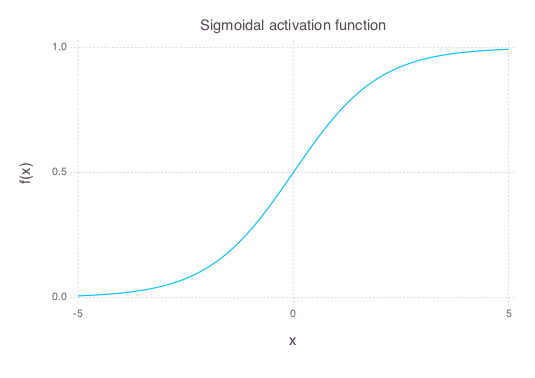

In [1]:
using Gadfly
function sigm(a)
    1. / (1. + exp(-a))
end
p = plot(sigm,-5,5,Guide.title("Sigmoidal activation function"))


### Gradient Descent 



Learning algorithms sound terrific. But how can we devise such algorithms for a neural network? Suppose we have a network of perceptrons that we'd like to use to learn to solve some problem. For example, the inputs to the network might be the raw pixel data from a scanned, handwritten image of a digit. And we'd like the network to learn weights and biases so that the output from the network correctly classifies the digit. To see how learning might work, suppose we make a small change in some weight (or bias) in the network. What we'd like is for this small change in weight to cause only a small corresponding change in the output from the network. As we'll see in a moment, this property will make learning possible.

#### Example

<img src="./gate1.jpg" width="300" align="left"/>

Consider a simple circuit which takes 2 inputs `x`, `y` and outputs its product `x*y`. 

$$f(x, y) = x*y$$

Now let us try to find a way to **increase the output slightly by tweaking the inputs slightly**.

Guessing some random values `x` = -1.99 and `y` = `2.99`, results in `x * y = -5.95`, which meets our objective of slight increase in output. 


The random search method might work on small data, but when the dimensions get bigger it is not practical to use. Another way is to imagine the desired change in the output, i.e., increase is slightly and intuit the forces on `x` and `y` which will aid this change in output.

In [2]:
x = -2 
y = 3
forwardMultiplyGate(x, y) = x*y

forwardMultiplyGate(-2, 3)

-6

In [3]:
forwardMultiplyGate(-1, 3)

-3

This change in output might be in the right direction, but the magnitude is bit too high.

In [4]:
forwardMultiplyGate(-1,4)

-4

In [5]:
x = -2;
y = 3;
out = forwardMultiplyGate(x, y); # before: -6
x_gradient = y; # by our complex mathematical derivation above
y_gradient = x;

step_size = 0.01;
x += step_size * x_gradient; # -2.03
y += step_size * y_gradient; # 2.98
out_new = forwardMultiplyGate(x, y); # -5.87. Higher output! Nice.

-5.8706

Above example helps us understand how partial derivatives help in calculating the **analytical gradient** which is widely used in defining the **Cost function** of a neural network.

The previous gate was very simple and the derivative too was straight forward. Let us add some complexity,

<img src="./gate2.jpg" width="300" align="left"/>

This is a combination of 2 gates, 

$$f(x,y,z) = (x + y) z$$


In [6]:

function forwardMultiplyGate(a, b) 
  return a * b;
end;
    
function forwardAddGate(a, b) 
  return a + b;
end;
        
function forwardCircuit(x,y,z) 
  q = forwardAddGate(x, y);
  r = forwardMultiplyGate(q, z);
  return r;
end

x = -2
y = 5
z = -4;
f2 = forwardCircuit(x, y, z); # output is -12

-12

In [7]:
function forwardMultiplyGate(a, b) 
  return a * b;
end

function forwardAddGate(a, b) 
  return a + b;
end;

function forwardCircuit(x,y,z)
  q = forwardAddGate(x, y);
  f = forwardMultiplyGate(q, z);
  return f;
end;

x = -2;
y = 5;
z = -4;
f = forwardCircuit(x, y, z); # output is -12

-12

In [8]:
# initial conditions
x = -2;
y = 5;
z = -4;
q = forwardAddGate(x, y); # q is 3
f = forwardMultiplyGate(q, z); # output is -12

# gradient of the MULTIPLY gate with respect to its inputs
# wrt is short for "with respect to"
derivative_f_wrt_z = q; # 3
derivative_f_wrt_q = z; # -4

# derivative of the ADD gate with respect to its inputs
derivative_q_wrt_x = 1.0;
derivative_q_wrt_y = 1.0;

# chain rule
derivative_f_wrt_x = derivative_q_wrt_x * derivative_f_wrt_q; # -4
derivative_f_wrt_y = derivative_q_wrt_y * derivative_f_wrt_q; # -4

-4.0

In [9]:
gradient_f_wrt_xyz = [derivative_f_wrt_x, derivative_f_wrt_y, derivative_f_wrt_z]

# let the inputs respond to the force/tug:
step_size = 0.01;
x = x + step_size * derivative_f_wrt_x; # -2.04
y = y + step_size * derivative_f_wrt_y; # 4.96
z = z + step_size * derivative_f_wrt_z; # -3.97

# Our circuit now better give higher output:
q = forwardAddGate(x, y); # q becomes 2.92
f = forwardMultiplyGate(q, z); # output is -11.59, up from -12! Nice!

-11.5924

### Digit Recognition using Logistic regression

This model is a good example to understand how a basic single layer neural network, let us read some digits from the data. 

In [10]:
Pkg.add("MNIST")
using MNIST

trainX, trainY = traindata()
testX, testY = testdata()

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of MNIST
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [11]:
function shownum(X, i)
    num = X[:,i]
    num = reshape(num, 28,28)
    
    num = num'./maximum(num)
    
    return grayim(num)
end

shownum (generic function with 1 method)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(50, nactions=1),"i",50,"50",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)),Any[],Any[],true,"horizontal")

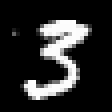

3.0

In [12]:
using Interact, Images
sample = @manipulate for i=1:100; i; end

display(map(i->shownum(trainX, i), sample))
display(map(i->trainY[i], sample))

Let us define a softmax function `soft` which is a generalization of a logistix function, which is used as a activation function.

In [13]:
soft(xs) = exp(xs)/sum(exp(xs))

soft (generic function with 1 method)

In [14]:
# Let the weights and the output be randomly initialised
W = rand(10, 784);
b = rand(10);

In [15]:
# Let us define the neural network
net(x) = soft(W*x + b)

net (generic function with 1 method)

In [16]:
# Let us try to classify ith image
i = 1
y_out = net(normalize(trainX[:,i]))

10-element Array{Float64,1}:
 0.072071 
 0.137355 
 0.0927478
 0.113934 
 0.119991 
 0.0827032
 0.110801 
 0.088311 
 0.097341 
 0.0847454

In [17]:
findmax(y_out)

(0.13735470950426432,2)

The network says that the digit is a `8` which is definitely wrong. Hence we modify the weights in such a way that the network learns how to classify the digit better.

In [18]:
η = 0.01
W = W .+ η

# Let us try to classify ith image
i = 1
y_out = net(normalize(trainX[:,i]))

10-element Array{Float64,1}:
 0.072071 
 0.137355 
 0.0927478
 0.113934 
 0.119991 
 0.0827032
 0.110801 
 0.088311 
 0.097341 
 0.0847454

In [19]:
findmax(y_out)

(0.13735470950426432,2)

## Deep Learning in Julia

What we just saw was a simplest 1 layer network, with softmax activation. It was apparent that the performance is not good, and we can stack up multiple such layers to gain better performance.

We look into simple multi-layer perceptron model to train on MNIST data and later we show how to do the same using a convolutional neural network.

### Simple 3-Layer MLP

<img src="./mlp2.jpg" width="450" align="left"/>

In [1]:
#Pkg.add("MXNet")
using MXNet

MXNet provides a symbolic API, which hides all the complexity of the network. Let us define the network architecture by starting with the data symbol. 

In [2]:
data = mx.Variable(:data)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007fbef2a33720))

In [3]:
# Cascading fully-connected layers and activation functions
fc1  = mx.FullyConnected(mx.SymbolicNode, data = data, name=:fc1, num_hidden=128)
act1 = mx.Activation(mx.SymbolicNode, data = fc1, name=:relu1, act_type=:relu)
fc2  = mx.FullyConnected(mx.SymbolicNode, data = act1, name=:fc2, num_hidden=64)
act2 = mx.Activation(mx.SymbolicNode, data = fc2, name=:relu2, act_type=:relu)
fc3  = mx.FullyConnected(mx.SymbolicNode, data = act2, name=:fc3, num_hidden=10)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007fbef29e4140))

Note each composition we take the previous symbol as the data argument, forming a feedforward chain. The architecture looks like,

`Input --> 128 units (ReLU) --> 64 units (ReLU) --> 10 units`

where the last 10 units correspond to the 10 output classes (digits 0,...,9). We then add a final SoftmaxOutput operation to turn the 10-dimensional prediction to proper probability values for the 10 classes:

In [4]:
mlp  = mx.SoftmaxOutput(mx.SymbolicNode, data = fc3, name=:softmax)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007fbef2978880))

As we can see, the MLP is just a chain of layers. For this case, we can also use the mx.chain macro. The same architecture above can be defined as

In [5]:
mlp = @mx.chain mx.Variable(:data)             =>
  mx.FullyConnected(name=:fc1, num_hidden=128) =>
  mx.Activation(name=:relu1, act_type=:relu)   =>
  mx.FullyConnected(name=:fc2, num_hidden=64)  =>
  mx.Activation(name=:relu2, act_type=:relu)   =>
  mx.FullyConnected(name=:fc3, num_hidden=10)  =>
  mx.SoftmaxOutput(name=:softmax)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007fbeefedc190))

After defining the architecture, we are ready to load the MNIST data. MXNet.jl provide built-in data providers for the MNIST dataset, which could automatically download the dataset into Pkg.dir("MXNet")/data/mnist if necessary. We wrap the code to construct the data provider into mnist-data.jl so that it could be shared by both the MLP example and the LeNet ConvNets example.

In [6]:
batch_size = 100
include(joinpath(Pkg.dir("MXNet"),"examples","mnist","mnist-data.jl"))
train_provider, eval_provider = get_mnist_providers(batch_size)

(MXNet.mx.MXDataProvider(MXNet.mx.MX_DataIterHandle(Ptr{Void} @0x00007fbef29ed870),Tuple{Symbol,Tuple}[(:data,(784,100))],Tuple{Symbol,Tuple}[(:softmax_label,(100,))],100,true,true),MXNet.mx.MXDataProvider(MXNet.mx.MX_DataIterHandle(Ptr{Void} @0x00007fbef29ca250),Tuple{Symbol,Tuple}[(:data,(784,100))],Tuple{Symbol,Tuple}[(:softmax_label,(100,))],100,true,true))

If you need to write your own data providers for customized data format you can use `mx.AbstractDataProvider`. 

Data providers are wrappers that load external data, be it images, text, or general tensors, and split it into mini-batches so that the model can consume the data in a uniformed way.


In [7]:
train_provider.data_shape

1-element Array{Tuple{Symbol,Tuple},1}:
 (:data,(784,100))

You can see from the aboe result that we have picked 100 images from the training data, and each image is of length `784 = 28*28`.

Given the architecture and data, we can instantiate an model to do the actual training. mx.FeedForward is the built-in model that is suitable for most feed-forward architectures. When constructing the model, we also specify the context on which the computation should be carried out. Because this is a really tiny MLP, we will just run on a single CPU device.

In [8]:
model = mx.FeedForward(mlp, context=mx.cpu())

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007fbeefedc190)),MXNet.mx.Context[CPU0],#undef,#undef,#undef)

You can use a mx.gpu() or if a list of devices (e.g. [mx.gpu(0), mx.gpu(1)]) is provided, data-parallelization will be used automatically. But for this tiny example, using a GPU device might not help.

The last thing we need to specify is the optimization algorithm (a.k.a. optimizer) to use. We use the basic SGD with a fixed learning rate 0.1 and momentum 0.9:

In [28]:
optimizer = mx.SGD(lr=0.1, momentum=0.9, weight_decay=0.00001)

MXNet.mx.SGD(MXNet.mx.SGDOptions(0.1,0.9,0,1.0e-5,MXNet.mx.LearningRate.Fixed(0.1),MXNet.mx.Momentum.Fixed(0.9)),#undef)

Now we can do the training. Here the n_epoch parameter specifies that we want to train for 20 epochs. We also supply a eval_data to monitor validation accuracy on the validation set.

In [29]:
@time mx.fit(model, optimizer, train_provider, n_epoch=20, eval_data=eval_provider)

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 0 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/020 ==========
INFO: ## Training summary
INFO:           accuracy = 0.7554
INFO:               time = 3.6442 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9502
INFO: == Epoch 002/020 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9582
INFO:               time = 2.6967 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9652
INFO: == Epoch 003/020 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9714
INFO:               time = 2.3133 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9718
INFO: == Epoch 004/020 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9786
INFO:               time = 2.0129 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9718
INFO: == Epoch 005/020 =========

### Convolutional Neural Networks

In the second example, we show a slightly more complicated architecture that involves convolution and pooling. This architecture for the MNIST is usually called the [LeNet]_. The first part of the architecture is listed below:

In [30]:
# input
data = mx.Variable(:data)

# first conv
conv1 = @mx.chain mx.Convolution(mx.SymbolicNode, data=data, kernel=(5,5), num_filter=20)  =>
                  mx.Activation(act_type=:tanh) =>
                  mx.Pooling(pool_type=:max, kernel=(2,2), stride=(2,2))

# second conv
conv2 = @mx.chain mx.Convolution(mx.SymbolicNode, data=conv1, kernel=(5,5), num_filter=50) =>
                  mx.Activation(act_type=:tanh) =>
                  mx.Pooling(pool_type=:max, kernel=(2,2), stride=(2,2))

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007f8d11376a90))

We basically defined two convolution modules. Each convolution module is actually a chain of Convolution, tanh activation and then max `Pooling` operations.

Each sample in the MNIST dataset is a 28x28 single-channel grayscale image. In the tensor format used by `NDArray`, a batch of 100 samples is a tensor of shape `(28,28,1,100)`. The convolution and pooling operates in the spatial axis, so `kernel=(5,5)` indicate a square region of 5-width and 5-height. The rest of the architecture follows as:

In [31]:
# first fully-connected
fc1   = @mx.chain mx.Flatten(conv2) =>
                  mx.FullyConnected(num_hidden = 500) =>
                  mx.Activation(act_type=:tanh)

# second fully-connected
fc2   = mx.FullyConnected(mx.SymbolicNode, data=fc1, num_hidden=10)

# softmax loss
lenet = mx.SoftmaxOutput(mx.SymbolicNode, data=fc2, name=:softmax)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00007f8d1158cce0))

Note a fully-connected operator expects the input to be a matrix. However, the results from spatial convolution and pooling are 4D tensors. So we explicitly used a Flatten operator to flat the tensor, before connecting it to the FullyConnected operator.

The rest of the network is the same as the previous MLP example. As before, we can now load the MNIST dataset:

In [32]:
batch_size = 100
include(joinpath(Pkg.dir("MXNet"),"examples","mnist","mnist-data.jl"))
train_provider, eval_provider = get_mnist_providers(batch_size; flat=false)

(MXNet.mx.MXDataProvider(MXNet.mx.MX_DataIterHandle(Ptr{Void} @0x00007f8d11801930),Tuple{Symbol,Tuple}[(:data,(28,28,1,100))],Tuple{Symbol,Tuple}[(:softmax_label,(100,))],100,true,true),MXNet.mx.MXDataProvider(MXNet.mx.MX_DataIterHandle(Ptr{Void} @0x00007f8d11b28750),Tuple{Symbol,Tuple}[(:data,(28,28,1,100))],Tuple{Symbol,Tuple}[(:softmax_label,(100,))],100,true,true))

Note we specified flat=false to tell the data provider to provide 4D tensors instead of 2D matrices because the convolution operators needs correct spatial shape information. We then construct a feedforward model on GPU, and train it.

In [ ]:
# fit model
model = mx.FeedForward(lenet, context=mx.cpu())

# optimizer
optimizer = mx.SGD(lr=0.05, momentum=0.9, weight_decay=0.00001)

# fit parameters
mx.fit(model, optimizer, train_provider, n_epoch=20, eval_data=eval_provider)

### Predicting with a trained model

Predicting with a trained model is very simple. By calling `mx.predict` with the model and a data provider, we get the model output as a Julia Array:

In [ ]:
probs = mx.predict(model, eval_provider)

In [ ]:
labels = Array[]
for batch in eval_provider
    push!(labels, copy(mx.get(eval_provider, batch, :softmax_label)))
end
labels = cat(1, labels...)

In [ ]:
sample = @manipulate for i=1:100; i; end

display(map(i->shownum(testX, i), sample))
display(map(i->labels[i], sample))

In [ ]:
i = 1
Int(labels[i])

In [ ]:
shownum(testX, i)